In [ ]:
!pip install tweepy

In [ ]:
import tweepy
import pandas as pd
import csv
from google.colab import drive

In [ ]:
consumer_key ='YOUR_CREDENTIALS'
consumer_secret ='YOUR_CREDENTIALS'
access_token_key ='YOUR_CREDENTIALS'
access_token_secret='YOUR_CREDENTIALS'

In [ ]:
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
#Estableciendo conexión
def api_connection():
  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_token_key,access_token_secret)
  api = tweepy.API(auth, wait_on_rate_limit=True)

  try:
    api.verify_credentials()
    print('Auth OK!')
  except Exception:
    print('Error!')

  return api

api = api_connection()

Auth OK!


In [ ]:
def extract_tweets(hashtag, count):
  api = api_connection()
  tweets = []
  for tweet in tweepy.Cursor(api.search, q=hashtag, lang='es', include_rts=False).items(count):
    if (not tweet.retweeted and 'RT @' not in tweet.text):
      tweets.append(tweet.text)
      #Podemos traer avatar, localización, verificada, hashtag, user_name, user_id
  return tweets


In [ ]:
print('DS Nike')
tweets = extract_tweets('#Nike', 50)
df = pd.DataFrame(data=tweets, columns=['text'])
path = f'drive/My Drive/Colab Notebooks/Project/Tweepy/tweets.csv'
df.to_csv(path,sep=',', index=False)

DS Nike
Auth OK!


In [ ]:
df = pd.read_csv(path)

In [ ]:
df.head(10)

,text
0,Ohhhh mira lo que me encontre 😍😍😍🥰🥰🥰 🔵⚪️...
1,"Ahí lo tienen, es Lebron James, mega estrella ..."
2,Esto se jodio #Nike Supreme/Air Jordan 1 para ...
3,⚽️🇪🇸 | #Sevilla mantiene a #Nike como su spons...
4,"Se re imagino el modelo de la infame ""Chicago ..."
5,Uff #Nike Air Force 1 y Air Max '90 summer col...
6,#nike hoy si que si rotura mas fiable del tria...
7,Chicago. #WingsLogoWednesdays.\n•\n#OGSupportG...
8,Quienes son los pendejos que van con unos #Jor...
9,Hay algo que #Nike te puede dar que #NewBalanc...


In [ ]:
import nltk 
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def transform(text):
  stopWords = set(stopwords.words('spanish'))
  text = str(text)
  text = re.sub(r'@[A-Za-z0-9]+',' ', text) # Remover menciones @AlvaroUribeVel
  text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
  text = re.sub(r'#',' ', text)# Remover hashtag en el tweet
  text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links

  words = text.lower().split()

  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  stripped = [re_punc.sub('', w) for w in words]
  no_garbage = [w for w in stripped if not w in stopWords]

  return(" ".join(no_garbage))

In [ ]:
df['tweets_transform'] = df['text'].apply(transform)

In [ ]:
df['tweets_transform'].head()

0    ohhhh mira encontre 😍😍😍🥰🥰🥰 🔵⚪️🔴🟡 nike airmoreu...
1    ahí lebron james mega estrella angeles lakers ...
2    jodio nike supremeair jordan 1 2021 saldelamon...
3    ⚽️🇪🇸  sevilla mantiene nike sponsor oficial ju...
4    re imagino modelo infame chicago colors jumpma...
Name: tweets_transform, dtype: object

Analysis sentiment

In [ ]:
from textblob import TextBlob

def set_Sentiment(text):
  text = str(text)
  if text != '':
    analysis = TextBlob(text)
    if analysis.detect_language() == 'es':
      analysis = analysis.translate(from_lang ='es', to='en').sentiment
      sentiment = analysis.polarity
      return sentiment

In [ ]:
df['polarity'] = df['tweets_transform'].apply(set_Sentiment)

In [ ]:
#-1 más negatividad, 1 más positiva

df['polarity'].head(10)

0    0.000000
1    0.136364
2    0.000000
3    0.000000
4         NaN
5    0.500000
6    0.080000
7         NaN
8    0.000000
9    0.000000
Name: polarity, dtype: float64

In [ ]:
df['text'][1]

'Ahí lo tienen, es Lebron James, mega estrella de los Angeles Lakers de la NBA 🏀 luciendo la nueva camiseta del Live… https://t.co/bPQtpGMm3b'

WordCloud

In [ ]:
from wordcloud import WordCloud

text = df.tweets_transform
text.head()

0    ohhhh mira encontre 😍😍😍🥰🥰🥰 🔵⚪️🔴🟡 nike airmoreu...
1    ahí lebron james mega estrella angeles lakers ...
2    jodio nike supremeair jordan 1 2021 saldelamon...
3    ⚽️🇪🇸  sevilla mantiene nike sponsor oficial ju...
4    re imagino modelo infame chicago colors jumpma...
Name: tweets_transform, dtype: object

In [ ]:
text = ' '.join(df.tweets_transform)
text

'ohhhh mira encontre 😍😍😍\U0001f970\U0001f970\U0001f970 🔵⚪️🔴\U0001f7e1 nike airmoreuptempo olympics  ponce puerto rico ahí lebron james mega estrella angeles lakers nba 🏀 luciendo nueva camiseta live… jodio nike supremeair jordan 1 2021 saldelamonotonia gnews enterate pasando… ⚽️🇪🇸  sevilla mantiene nike sponsor oficial junio 2022 re imagino modelo infame chicago colors jumpman23 nike air jordan 1 high og satin snake… uff nike air force 1 air max 90 summer colors niños encantan saldelamonotonia gnews enterate… nike hoy si si rotura mas fiable triangulo vela marubozu mismo objetivo marcaba hace unas s… chicago wingslogowednesdays • ogsupportgroup jumpman jumpman23 nike possibletogether preparetofly… pendejos van jordan comprar nike nike forever nike puede dar newbalance visibilidad mundial allá lebron accionista… pesar años aún actual gigante marca nike dispuesto ir jordan nike nba cancha estilo⚽👕🏀 lebron james accionista liverpool celebró llegada nike club utilizan… lebron james nueva c

In [ ]:
wordcloud = WordCloud(width=1024, height=800, background_color='white', min_font_size=14).generate(text)

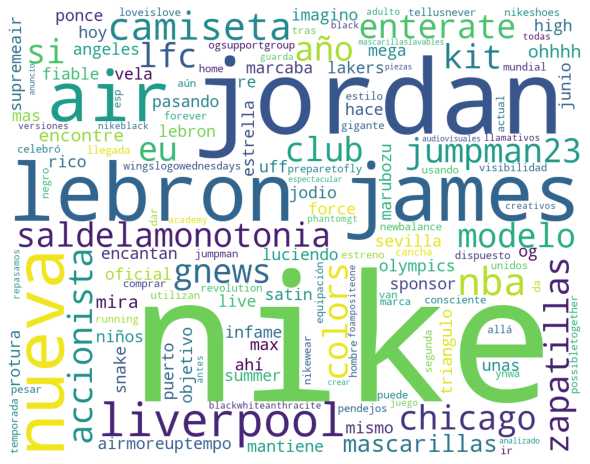

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()